# Domain Generation Algorithm Detection Project
Rachel Qu, Jan 2019

* The purpose of this project is to rapidly and accurately detect DGA with ML model based on URL information caputred in network traffic.
* This project has three parts: data preparation, model training and evaluation, and model deployment.
* Data preparation, model training and evaluation will be explained in this notebook.

* In the process of data preparation, external information (common TLD) is downloaded from https://www.icann.org/resources/pages/tlds-2012-02-25-en

* In the process of model training and evaluation, bigram model, LSTM RNN model, ensemble model are built. Performances are evaluted on same test data for these three models. Bigram model is the baseline model. Ensemble model is the model that goes into deployment. 


## Phase 1: Data Preparation
* In this part, the dga dataset was cleaned. 
* Cleaning processes include: reading dga-dataset.txt as pandas dataframe using 'ctrl-A' as delimiter, adding header, converting all valus into lowercase, seperating domain into primary domain and TLD, remove instances with empty label.

In [1]:
# import necessary packages and change working directory 
import pandas as pd
import os
r = '/Users/Rachel/Desktop/Career/FullTime/Interview Materials/Secureworks/Coding Challenge/'
os.chdir(r)

In [2]:
# read the dga-dataset using 'ctrl-A' as delimiter 
# add three original columns
dga = pd.read_csv('dga-dataset.txt', sep = chr(1), header = None)
dga.columns = ['domain','origin','label']

In [3]:
# check sample data
dga.head()

,domain,origin,label
0,bmskafjfoenhf.ru,cryptolocker,dga
1,hollywoodreporter.com,NaN,legit
2,wikiseda.com,NaN,legit
3,ns1.experience.com,NaN,legit
4,lockheedmartin.com,NaN,LEGIT


In [4]:
# convert all values into lowercase
dga = dga.apply(lambda x: x.astype(str).str.lower())
# add a column named 'domain_list' -  in order to seperate it into detailed domain information later
dga['domain_list'] = dga['domain'].apply(lambda x: x.split('.'))
dga.head()

,domain,origin,label,domain_list
0,bmskafjfoenhf.ru,cryptolocker,dga,"[bmskafjfoenhf, ru]"
1,hollywoodreporter.com,nan,legit,"[hollywoodreporter, com]"
2,wikiseda.com,nan,legit,"[wikiseda, com]"
3,ns1.experience.com,nan,legit,"[ns1, experience, com]"
4,lockheedmartin.com,nan,legit,"[lockheedmartin, com]"


* To process URLs into primary domain and tld, common tld informtion is used here.
* For instances with more than 2 elements in URLs, the last two elements in 'domain_list' are looked up in common tld list in order to figure out the proper segmentation of URLs.

In [5]:
# analyse domain_list

# first, deal with instances with only two elements(pri+tld) in 'domain_list'
dga2 = dga[dga['domain_list'].apply(lambda x: True if len(x)==2 else False)]
# split them into two columns as primary1 and tld1
# add two empty columns:primary2 and tld2
dga2['primary1'] = dga['domain_list'].apply(lambda x: x[0])
dga2['primary2'] = ''
dga2['tld1'] = dga['domain_list'].apply(lambda x: x[1])
dga2['tld2'] = ''
dga2.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,domain,origin,label,domain_list,primary1,primary2,tld1,tld2
0,bmskafjfoenhf.ru,cryptolocker,dga,"[bmskafjfoenhf, ru]",bmskafjfoenhf,,ru,
1,hollywoodreporter.com,nan,legit,"[hollywoodreporter, com]",hollywoodreporter,,com,
2,wikiseda.com,nan,legit,"[wikiseda, com]",wikiseda,,com,
4,lockheedmartin.com,nan,legit,"[lockheedmartin, com]",lockheedmartin,,com,
5,twitter.com,nan,legit,"[twitter, com]",twitter,,com,


In [6]:
# read common TLD information from TLDlist.txt(downloaded from ICANN)
# skip comments, use '/n' as delimiter, convert into lowercase
from numpy import loadtxt
tld = loadtxt("DGA_Detection/TLDlist.txt", dtype=str, comments="#", delimiter="/n", unpack=False)
tld = [x.lower() for x in tld]

In [7]:
# deal with instances with three elements in 'domain_list'

dga3 = dga[dga['domain_list'].apply(lambda x: True if len(x)==3 else False)]

# for instances with three domain elements(pri1+tld1+tld2, both tld1 and tld2 belong to common TLD)
# split them into three columns as primary1, tld1, tld2
# add one empty column primary2
dga3_1 = dga3[dga3['domain_list'].apply(lambda x: True if x[-2] in tld and x[-1] in tld else False)]
dga3_1['primary1'] = dga3['domain_list'].apply(lambda x: x[0])
dga3_1['primary2'] = ''
dga3_1['tld1'] = dga3['domain_list'].apply(lambda x: x[1])
dga3_1['tld2'] = dga3['domain_list'].apply(lambda x: x[2])

# for instances with three domain elements(sub+pri+tld1, tld1 belongs to common TLD)
dga3_2 = dga3[dga3['domain_list'].apply(lambda x: True if x[-2] not in tld and x[-1] in tld else False)]
# split them into two columns as primary1, tld1
# add two emtpy columns primary2, tld2
dga3_2['primary1'] = dga3_2['domain_list'].apply(lambda x: x[1])
dga3_2['primary2'] = ''
dga3_2['tld1'] = dga3_2['domain_list'].apply(lambda x: x[2])
dga3_2['tld2'] = ''

# for instances with three domain elements(sub+pri+tld1, tld1 doesn't belong to common TLD)
dga3_3 = dga3[dga3['domain_list'].apply(lambda x: True if x[-2] not in tld and x[-1] not in tld else False)]
# split them into two columns as primary1, tld1
# add two emtpy columns primary2, tld2
dga3_3['primary1'] = dga3_3['domain_list'].apply(lambda x: x[1])
dga3_3['primary2'] = ''
dga3_3['tld1'] = dga3_3['domain_list'].apply(lambda x: x[2])
dga3_3['tld2'] = ''

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [8]:
# deal with instances with four element in 'domain_list'

dga4 = dga[dga['domain_list'].apply(lambda x: True if len(x)== 4 else False)]

# for instances with four domain elements(sub+pri1+tld1+tld2, both tld1 and tld2 belong to common TLD)
# split them into three columns as primary1, tld1, tld2
# add one empty column primary2
dga4_1 = dga4[dga4['domain_list'].apply(lambda x: True if x[-2] in tld and x[-1] in tld else False)]
dga4_1['primary1'] = dga4_1['domain_list'].apply(lambda x: x[1])
dga4_1['primary2'] = ''
dga4_1['tld1'] = dga4_1['domain_list'].apply(lambda x: x[2])
dga4_1['tld2'] = dga4_1['domain_list'].apply(lambda x: x[3])

# for instances with four domain elements(sub+pri2+pri1+tld1, tld1 belongs to common TLD)
# split them into three columns as primary1, primary2, tld1
# add one empty column tld2
dga4_2 = dga4[dga4['domain_list'].apply(lambda x: True if x[-2] not in tld and x[-1] in tld else False)]
dga4_2['primary1'] = dga4_2['domain_list'].apply(lambda x: x[2])
dga4_2['primary2'] = dga4_2['domain_list'].apply(lambda x: x[1])
dga4_2['tld1'] = dga4_2['domain_list'].apply(lambda x: x[3])
dga4_2['tld2'] = ''

# for instances with four domain elements(sub+pri2+pri1+tld1, tld1 doesn't belong to common TLD)
# split them into three columns as primary1, primary2, tld1
# add one empty column tld2
dga4_3 = dga4[dga4['domain_list'].apply(lambda x: True if x[-2] not in tld and x[-1] not in tld else False)]
dga4_3['primary1'] = dga4_3['domain_list'].apply(lambda x: x[2])
dga4_3['primary2'] = dga4_3['domain_list'].apply(lambda x: x[1])
dga4_3['tld1'] = dga4_3['domain_list'].apply(lambda x: x[3])
dga4_3['tld2'] = ''

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [9]:
# deal with instances with five elements in ‘domain_list’

dga5 = dga[dga['domain_list'].apply(lambda x: True if len(x)== 5 else False)]

# select instances with structure of sub1+pri2+pri1+tld1+tld2
# split them into four columns primary1, primary2, tld1, tld2
dga5['primary1'] = dga5['domain_list'].apply(lambda x: x[2])
dga5['primary2'] = dga5['domain_list'].apply(lambda x: x[1])
dga5['tld1'] = dga5['domain_list'].apply(lambda x: x[3])
dga5['tld2'] = dga5['domain_list'].apply(lambda x: x[4])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

* combine cleaning results of several steps above to get a new dataframe, then clean 'label' column and instances with empty 'label' value

In [10]:
# organize above datasets into a final dataset as dga_new
dga_new = pd.concat([dga2, dga3_1, dga3_2, dga3_3, dga4_1, dga4_2, dga4_3, dga5], ignore_index=True)

In [11]:
# clean the target variable 'label'
# delete the record with 'nan' value on 'label' column
dga_new['label'] = dga_new['label'].apply(lambda x: 'dga' if x in ('dg','da','dgb','dgs','dgf','dha')\
                                    else'legit' if x in ('lgit','lenit','lefit','legip') else x)
dga_new = dga_new[dga_new['label']!='nan']

In [12]:
dga_new.head()

,domain,origin,label,domain_list,primary1,primary2,tld1,tld2
0,bmskafjfoenhf.ru,cryptolocker,dga,"[bmskafjfoenhf, ru]",bmskafjfoenhf,,ru,
1,hollywoodreporter.com,nan,legit,"[hollywoodreporter, com]",hollywoodreporter,,com,
2,wikiseda.com,nan,legit,"[wikiseda, com]",wikiseda,,com,
3,lockheedmartin.com,nan,legit,"[lockheedmartin, com]",lockheedmartin,,com,
4,twitter.com,nan,legit,"[twitter, com]",twitter,,com,


In [13]:
# select five columns to build DGA_Detection model
dga_cleaned = dga_new[['primary1','primary2','tld1','tld2','label']]

In [14]:
dga_cleaned.head()

,primary1,primary2,tld1,tld2,label
0,bmskafjfoenhf,,ru,,dga
1,hollywoodreporter,,com,,legit
2,wikiseda,,com,,legit
3,lockheedmartin,,com,,legit
4,twitter,,com,,legit


In [15]:
dga_cleaned.shape

(157926, 5)

## Phase 2: Model Training and Evaluation
* In this part, three DGA_Detection model is trained and evaluated. 
* Bigram model is known for its ability to deal with text data, and it is used as baseline model here. 


* According to Hyrum Anderson, LSTM RNN model usually give better peformances on the detecion of DGA with only primary domain as feature due to its long short term learning ability.(https://www.endgame.com/blog/technical-blog/using-deep-learning-detect-dgas, Nov 18, 2016). Therefore, a LSTM RNN model with primary domain as feature is created to improve the performance. 

* Based on Ryan R.Curtin's study, some DGA families such as gozi and matsnu are harder for normal detection models to detect, since they generate English-like domain names, which are even difficult for human to detect. Utlizing ensemble method and combining other side information, such as TLD information and domain registration information, is likely to imporve the model performance.(https://arxiv.org/abs/1810.02023, Oct 4,2018).Therefore, a ensemble model that encorporates prediction result of LSTM RNN model and one-hot encoding of top 250 TLDs in dataset is used here to increase performance.

### Phase 2.1: Baseline Bigram Model

In [17]:
# import necessary resources
from keras.layers.core import Dense
from keras.models import Sequential
import sklearn
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split

In [38]:
# build baseline bigram model
def build_baseline(max_features):
    model = Sequential()
    model.add(Dense(1, input_dim=max_features, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam')

    return model

In [35]:
# take only 'primary1' as input
dga_base = dga_cleaned[['label','primary1']]

In [47]:
# defining bigram model training and testing function
def run_baseline(dga_base, max_epoch=50, batch_size=128):
    
    # extract data and labels for bigram baseline model
    # baseline model only use primary1 as feature
    indata  = dga_base.values.tolist()
    X = [x[1] for x in indata]
    labels = [x[0] for x in indata]
    
    # create feature vectors
    ngram_vectorizer = feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(2, 2))
    count_vec = ngram_vectorizer.fit_transform(X)
    max_features = count_vec.shape[1]
    
    # convert labels
    y = [0 if x == 'legit' else 1 for x in labels]
    final_data = []
    
    # split data into training and test data
    # use random_state = 0 to keep same spliting result among three models
    X_train, X_test, y_train, y_test, _, label_test = train_test_split(count_vec, y,
                                                                       labels, test_size=0.2,random_state = 0)

    model = build_baseline(max_features)

    # split training data again into training and validation
    # use random_state = 0 to keep same spliting result among three models
    print ("Train...")
    X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.05,random_state = 0)
    best_iter = -1
    best_auc = 0.0
    out_data = {}

    # fit models and print model performance
    for ep in range(max_epoch):
        model.fit(X_train.todense(), y_train, batch_size=batch_size, nb_epoch=1)

        t_probs = model.predict_proba(X_holdout.todense())
        t_auc = sklearn.metrics.roc_auc_score(y_holdout, t_probs)

        print ('Epoch %d: auc = %f (best=%f)' % (ep, t_auc, best_auc))

        if t_auc > best_auc:
            best_auc = t_auc
            best_iter = ep

            probs = model.predict_proba(X_test.todense())

            out_data = {'y':y_test, 'labels': label_test, 'probs':probs, 'epochs': ep,
                        'confusion_matrix': sklearn.metrics.confusion_matrix(y_test, probs > .5)}

            print ("confusion matrix on test data:")
            print (sklearn.metrics.confusion_matrix(y_test, probs > .5))
        else:
            # stop the process if performance no longer improves...break and calculate statistics
            if (ep-best_iter) > 5:
                break

    final_data.append(out_data)

    return model, final_data

In [42]:
# get predictions and performance on test data
model_baseline, result_baseline = run_baseline(dga_base)

Train...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
120023/120023 [==============================] - 2s 13us/step - loss: 0.4512
Epoch 0: auc = 0.972994 (best=0.000000)
confusion matrix on test data:
[[14749  1513]
 [ 1113 14211]]
Epoch 1/1
120023/120023 [==============================] - 1s 12us/step - loss: 0.2896
Epoch 1: auc = 0.985310 (best=0.972994)
confusion matrix on test data:
[[15434   828]
 [  983 14341]]
Epoch 1/1
120023/120023 [==============================] - 1s 12us/step - loss: 0.2237
Epoch 2: auc = 0.992296 (best=0.985310)
confusion matrix on test data:
[[15613   649]
 [  722 14602]]
Epoch 1/1
120023/120023 [==============================] - 2s 13us/step - loss: 0.1827
Epoch 3: auc = 0.994938 (best=0.992296)
confusion matrix on test data:
[[15815   447]
 [  710 14614]]
Epoch 1/1
120023/120023 [==============================] - 2s 13us/step - loss: 0.1543
Epoch 4: auc = 0.996445 (best=0.994938)
confusion matrix on test data:
[[15868   394]
 [  621 14703]]
Epoch 1/1
120023/120023 [==============================

In [43]:
# save the bigram baseline model 
from pickle import dump
model_baseline.save('baseline_model.h5')

Summary of binary model:
* The dga-dataset is pretty balanced (from exploratory analysis).Bigram model achieves a auc of 0.998 on test data. Among 31586 records, 30860 records are correctly classified, which yields an accuracy of 97.7% on test data. In dga-detecion, we care about both FP and FN. FP is desired to be lower, since legit network traffic will be blocked otherwise. FN is also desired to be lower, otherwise, dga will miss detection and cause trouble to information security. 

### Phase 2.2: LSTM RNN Model

In [44]:
# import necessary resources
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

In [45]:
# build LSTM RNN model
def build_lstm(max_features, maxlen):
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop')

    return model

In [65]:
# define LSTM RNN model training and testing function
def run_lstm(dga_base, max_epoch=50, batch_size=128):
    
    # extract data and labels 
    indata  = dga_base.values.tolist()
    X = [x[1] for x in indata]
    labels = [x[0] for x in indata]

    # generate a dictionary of valid characters
    valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}
    max_features = len(valid_chars) + 1
    maxlen = np.max([len(x) for x in X])

    # convert characters to int and pad
    X = [[valid_chars[y] for y in x] for x in X]
    X = sequence.pad_sequences(X, maxlen=maxlen)

    # convert labels to 0-1
    y = [0 if x == 'legit' else 1 for x in labels]

    final_data = []

    # split data into training and test data
    # use random_state = 0 to keep same spliting result among three models
    X_train, X_test, y_train, y_test, _, label_test = train_test_split(X, y, labels, 
                                                               test_size=0.2, random_state = 0)

    model = build_lstm(max_features, maxlen)

    # split training data again into training and validation data
    # use random_state = 0 to keep same spliting result among three models
    X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.05,random_state = 0)
    best_iter = -1
    best_auc = 0.0
    out_data = {}

    for ep in range(max_epoch):
        model.fit(X_train, y_train, batch_size=batch_size, epochs=1)

        t_probs = model.predict_proba(X_holdout)
        t_auc = sklearn.metrics.roc_auc_score(y_holdout, t_probs)

        print ('Epoch %d: auc = %f (best=%f)' % (ep, t_auc, best_auc))

        if t_auc > best_auc:
            best_auc = t_auc
            best_iter = ep

            probs = model.predict_proba(X_test)

            out_data = {'y':y_test, 'labels': label_test, 'probs':probs, 'epochs': ep,
                            'confusion_matrix': sklearn.metrics.confusion_matrix(y_test, probs > .5)}
            
            print ("confusion matrix on test data:")
            print (sklearn.metrics.confusion_matrix(y_test, probs > .5))
        else:
            # stop the process if performance no longer improves...break and calculate statistics
            if (ep-best_iter) > 2:
                break

        final_data.append(out_data)

    return valid_chars, model,final_data

In [66]:
# get predictions and performance of LSTM model on test data
valid_chars, model_lstm, result_lstm = run_lstm(dga_base)

Epoch 1/1
120023/120023 [==============================] - 85s 708us/step - loss: 0.1319
Epoch 0: auc = 0.996149 (best=0.000000)
confusion matrix on test data:
[[15961   301]
 [  924 14400]]
Epoch 1/1
120023/120023 [==============================] - 83s 695us/step - loss: 0.0838
Epoch 1: auc = 0.997390 (best=0.996149)
confusion matrix on test data:
[[15898   364]
 [  556 14768]]
Epoch 1/1
120023/120023 [==============================] - 88s 730us/step - loss: 0.0703
Epoch 2: auc = 0.997986 (best=0.997390)
confusion matrix on test data:
[[15976   286]
 [  496 14828]]
Epoch 1/1
120023/120023 [==============================] - 87s 725us/step - loss: 0.0630
Epoch 3: auc = 0.998162 (best=0.997986)
confusion matrix on test data:
[[15962   300]
 [  452 14872]]
Epoch 1/1
120023/120023 [==============================] - 89s 739us/step - loss: 0.0585
Epoch 4: auc = 0.998459 (best=0.998162)
confusion matrix on test data:
[[15844   418]
 [  241 15083]]
Epoch 1/1
120023/120023 [====================

In [67]:
# save the lstm model
model_lstm.save('lstm_model.h5')

In [237]:
# save dictionary of valid characters in data set
import pickle
pkl_file = "valid_chars.pkl"  
with open(pkl_file, 'wb') as file:  
    pickle.dump(valid_chars, file)

Summary of LSTM model:
* LSTM model achieves a auc of 0.9989 on test data. Among 31586 records, 31025 records are correctly classified, which yields an accuracy of 98.2% on test data. 
* Compared with bigram model, LSTM model does yield a better performance: higher accuracy on test data, less false positives and less false negatives.
* But LSTM model does take much longer time to train than bigram model.

### Phase 2.3: Ensemble Model
* Ensemble model combines the prediction results of LSTM model and one-hot encoding of top 250 TLDs in data

In [101]:
# get top 250 TLDs in data
top_tld = dga_cleaned.tld1.value_counts()[0:250].index.values
top_tld

array(['com', 'ru', 'net', 'org', 'co', 'biz', 'de', 'fr', 'it', 'jp',
       'info', 'pl', 'es', 'in', 'nl', 'ca', 'tv', 'ir', 'gr', 'gov',
       'cn', 'eu', 'se', 'cz', 'be', 'edu', 'ro', 'at', 'me', 'ch', 'us',
       'hu', 'cl', 'dk', 'pt', 'vn', 'ua', 'no', 'sk', 'fi', 'ie', 'cc',
       'mx', 'ac', 'bg', 'ws', 'kz', 'az', 'to', 'ae', 'mobi', 'su', 'pk',
       'by', 'hk', 'sg', 'hr', 'lt', 'rs', 'io', 'xxx', 'tw', 'lk',
       'asia', 'si', 'ne', 'my', 'id', 'ph', 'kr', 'pe', 'jobs', 'fm',
       'am', 'tr', 'ee', 'ma', 'name', 'mk', 'pro', 'pw', 'mn', 'tk',
       'blog', 'is', 'lv', 'ec', 'ba', 'al', 'la', 'uz', 'ag', 'nu', 'pa',
       'bz', 'uk', 'cfa', 'ge', 'hdfc', 'br', 'bt', 'maif', 'do', 'nike',
       'docs', 'news', 'pm', 'cw', 'jot', 'so', 'ni', 'nfl', 'tn', 'gbiz',
       'im', 'md', 'qa', 'lu', 'sx', 'kg', 'jll', 'kfh', 'nz', 'tel',
       'gm', 'th', 'gp', 'aig', 'wine', 'ly', 'hair', 'law', 'dell',
       'cat', 'mu', 'saxo', 'dog', 'cm', 'tips', 'mp', 'ibm', 'hi

In [102]:
# perform one hot encoding on top 250 tld
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(top_tld)
# transform column tld1 of dga_cleaned
test = pd.DataFrame(lb.transform(dga_new['tld1']))

In [243]:
# save labelbinarizer lb and top tld
pkl_file1 = "labelbinarizer.pkl"  
with open(pkl_file1, 'wb') as file:  
    pickle.dump(lb, file)
    
pkl_file2 = "top_tld.pkl"  
with open(pkl_file2, 'wb') as file:  
    pickle.dump(top_tld, file)

In [104]:
# concat two dataframe in order to use tld information as input for ensemble model
test.reset_index(drop=True, inplace=True)
dga_new.reset_index(drop=True, inplace=True)
dga_cleaned = pd.concat( [dga_new, test], axis=1) 
dga_cleaned.head()

,domain,origin,label,domain_list,primary1,primary2,tld1,tld2,0,1,...,240,241,242,243,244,245,246,247,248,249
0,bmskafjfoenhf.ru,cryptolocker,dga,"[bmskafjfoenhf, ru]",bmskafjfoenhf,,ru,,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hollywoodreporter.com,nan,legit,"[hollywoodreporter, com]",hollywoodreporter,,com,,0,0,...,0,0,0,0,0,0,0,0,0,0
2,wikiseda.com,nan,legit,"[wikiseda, com]",wikiseda,,com,,0,0,...,0,0,0,0,0,0,0,0,0,0
3,lockheedmartin.com,nan,legit,"[lockheedmartin, com]",lockheedmartin,,com,,0,0,...,0,0,0,0,0,0,0,0,0,0
4,twitter.com,nan,legit,"[twitter, com]",twitter,,com,,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# add a column named 'lstm_probs' from the predcition results of lstm model

dga_base = dga_cleaned[['label','primary1']]
dga_base = dga_base.values.tolist()
X = [x[1] for x in dga_base]
maxlen = np.max([len(x) for x in X])

# Convert characters to int and pad
X = [[valid_chars[y] for y in x] for x in X]
X = sequence.pad_sequences(X, maxlen=maxlen)

# get predictions and concat the results to dataframe
lstm_probs = model_lstm.predict_proba(X)
lstm_probs = pd.DataFrame(lstm_probs)
lstm_probs.columns = ['lstm_probs']
lstm_probs.reset_index(drop=True, inplace=True)
dga_cleaned.reset_index(drop=True, inplace=True)
dga_cleaned = pd.concat([dga_cleaned, lstm_probs], axis=1)

In [111]:
# prepare data for ensemble model

# drop useless columns
columns = ['domain','origin','domain_list','primary1','primary2','tld1','tld2']
dga_cleaned.drop(columns, inplace=True, axis=1)
dga_cleaned.head()

,label,0,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,lstm_probs
0,dga,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.999995e-01
1,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.075579e-02
2,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.342431e-05
3,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.805882e-04
4,legit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.343607e-07


In [120]:
# build ensemble model (use LR)
from sklearn.linear_model import LogisticRegression
X = dga_cleaned.iloc[:, 1:]
y = dga_cleaned.iloc[:,0]

# split data into training and test data
# use random_state = 0 to keep same spliting result among three models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# fit the model
clf = LogisticRegression(random_state=0, multi_class='ovr', n_jobs = -1).fit(X, y)

# get prediction results
y_score = clf.predict_proba(X_test) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [146]:
# save the final model
import pickle
pkl_filename = "lrensemble_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(clf, file)

In [134]:
clf.score(X_test, y_test)

0.9905654403849807

In [131]:
# check performance of ensemble model on test data
# auc
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score[:,1])

0.9996287864655319

In [142]:
# get confusion matrix of ensemble model
y_test1 = [0 if x == 'legit' else 1 for x in y_test]
lr_confusion = sklearn.metrics.confusion_matrix(y_test1, y_score[:,0] > .5)

In [143]:
lr_confusion

array([[16067,   195],
       [  103, 15221]])

Summary of ensemble model:
* Ensemble model achieves a auc of 0.9996 on test data. Among 31586 records, 31288 records are correctly classified, which yields an accuracy of 99.1% on test data. 
* Compared with bigram model and LSTM model, ensemble model has the best performance: the highest accuracy on test data, the least false positives and false negatives.
* Once LSTM model is trained, the training time for ensemble method is pretty short. Compared with the other two models, ensemble method is the most complex.

### Phase 2.4: Model Evaluation
* In this part, performances(precision, recall) are compard for three models
* A detailed analysis of model performance is only explained for the ensemble model.

In [150]:
# import necessary resources
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve

In [228]:
# compare performance of three models
def plot_comparison(y_true,y_score_1,y_score_2,y_score_3, name_1,name_2, name_3 ,thre=0.5,save_name=None):

    fig = plt.figure(1,figsize=(5,5))

    precision1,recall1,thresholds1 = precision_recall_curve(y_true, y_score_1)
    precision2,recall2,thresholds2 = precision_recall_curve(y_true, y_score_2)
    precision3,recall3,thresholds3 = precision_recall_curve(y_true, y_score_3)
    
    plt.step(recall1, precision1, label=name_1, color='b', alpha=0.5,where='post')
    plt.step(recall2, precision2, label=name_2, color='r', alpha=0.5,where='post')
    plt.step(recall3, precision3, label=name_3, color='g', alpha=0.5,where='post')
    
    ppoint1 = precision1[:-1][np.argmin(np.abs(thresholds1 - thre))]
    rpoint1 = recall1[:-1][np.argmin(np.abs(thresholds1 - thre))]
    plt.plot(rpoint1, ppoint1, 'bo', markersize=7, label='thre'+str(thre))
    
    ppoint2 = precision2[:-1][np.argmin(np.abs(thresholds2 - thre))]
    rpoint2 = recall2[:-1][np.argmin(np.abs(thresholds2 - thre))]
    plt.plot(rpoint2, ppoint2, 'ro', markersize=7, label='thre'+str(thre))
    
    ppoint3 = precision3[:-1][np.argmin(np.abs(thresholds3 - thre))]
    rpoint3 = recall3[:-1][np.argmin(np.abs(thresholds3 - thre))]
    plt.plot(rpoint3, ppoint3, 'go', markersize=7, label='thre'+str(thre))
    
    # set start point of ylim and x lim to 0.9 since each of the three has an auc above 0.9
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.9, 1.00])
    plt.xlim([0.9, 1.00])
    plt.legend()
    plt.title('Precision Recall Curve')
    plt.show()
    if save_name: fig.savefig(save_name,bbox_inches='tight')

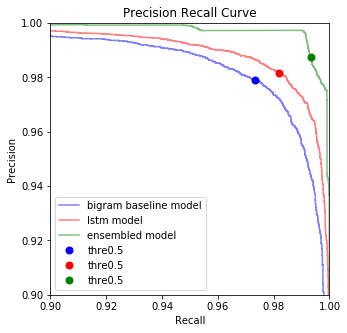

In [230]:
# plot performances of three models
plot_comparison(y_test1, result_baseline[0]['probs'], result_lstm[9]['probs'], \
                y_score[:,0],'bigram baseline model', 'lstm model','ensembled model')

In [234]:
# detailed performance analysis function
def plot_performance(out_true,out_pred,save_name=None):
    
    # get output
    precision,recall,thresholds = precision_recall_curve(out_true,out_pred)
    fpr,tpr,_  = roc_curve(out_true,out_pred)
    
    # get roc curve
    fig = plt.figure(1,figsize=(18,3))
    plt.subplot(141)
    plt.plot(fpr,tpr, color='darkorange',lw=2,label='ROC (area = %0.3f)' % auc(fpr,tpr))
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')
    plt.title("ROC")
    plt.legend(loc="lower right")    
    
    # get precision and recall curve
    plt.subplot(142)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
    plt.title('Precision Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot((0,1),(0.5,0.5),'k--')
    
    # precision threshold
    plt.subplot(143)
    plt.scatter(thresholds, precision[:-1], color='k',s=1)
    plt.title('Precision Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid()
    plt.plot((0,1),(0.5,0.5),'k--')
    
    # get calibration curve
    plt.subplot(144)
    fraction_of_positives,mean_predicted_value = calibration_curve(out_true,out_pred,n_bins=5)
    plt.plot(mean_predicted_value,fraction_of_positives)
    plt.title('Calibration')
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.grid()
    plt.plot((0,1),'k--')
    plt.show()
    if save_name: fig.savefig(save_name,bbox_inches='tight')

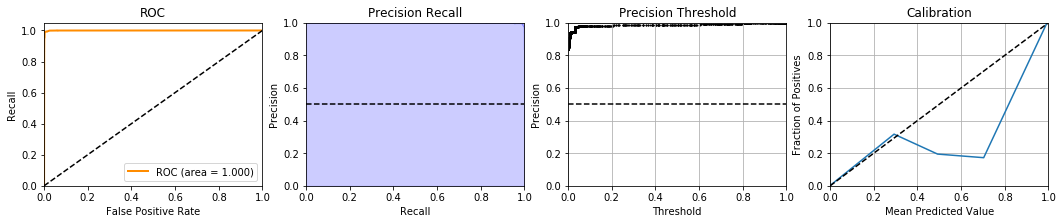

In [235]:
# plot performances of ensemble model
plot_performance(y_test1, y_score[:,0])

* Ensemble model achieves both a high recall and a high precision, indicating the ensemble model has a high ability of detecting dga points of interests in dataset, as well as a high ability of detecting only the relevant data points. 
* But the calibratin indicates that the model need to be calibrated, since it tends to predcit larger values and is over confident for now. 